In [24]:
import pandas as pd
from pathlib import Path
import pymc as pm
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from estival.model import BayesianCompartmentalModel
import estival.priors as esp
import estival.targets as est
from estival.wrappers import pymc as epm
from tbdynamics import model
from tbdynamics.utils import round_sigfig
from tbdynamics.inputs import load_params, matrix
from tbdynamics.constants import age_strata, organ_strata, compartments, latent_compartments, infectious_compartments
from tbdynamics.plotting import plot_model_vs_actual
import matplotlib.pyplot as plt
import seaborn as sns

## Define variables

In [2]:
PROJECT_PATH = Path().resolve()
DATA_PATH = PROJECT_PATH / 'data'
pd.options.plotting.backend = "plotly"

time_start = 1700.0
time_end = 2023.0
time_step = 0.1
matrix_homo = np.ones((6, 6)) # Homo mixing


In [3]:
fixed_parameters = load_params(PROJECT_PATH / 'tbdynamics/params.yml')

## Define Model

### Base model

In [4]:
tb_model = model.build_model(
    compartments,
    latent_compartments,
    infectious_compartments,
    age_strata,
    time_start,
    time_end,
    time_step,
    fixed_parameters,
    matrix
)

### Params and calibration targets

In [5]:
params = {}


priors = [
    esp.UniformPrior("start_population_size", (100000, 30000000)),
    esp.UniformPrior("contact_rate", (0.0001, 0.2)),  # multiplied with eigenvalue
    esp.UniformPrior("rr_infection_latent", (0.2, 0.5)),
    esp.UniformPrior("rr_infection_recovered", (0.1, 0.5)),
    esp.UniformPrior("progression_multiplier", (0.1, 10.0)),
    esp.UniformPrior("seed_time", [1700.0, 1900.0]),
    esp.UniformPrior("seed_duration", [1.0, 5.0]),
    esp.UniformPrior("seed_num", [1.0, 1500.0]),
    esp.UniformPrior("smear_positive_death_rate", (0.335, 0.449)),
    esp.UniformPrior("smear_negative_death_rate", (0.017, 0.035)),
    esp.UniformPrior("smear_positive_self_recovery", (0.177, 0.288)),
    esp.UniformPrior("smear_negative_self_recovery", (0.073, 0.209)),
]

pop = pd.Series(
    {
        2009: 86025000,
        2019: 96484000,
    }
)

notifs = pd.Series(
    {
        2010: 99022,
        2011: 100518,
        2012: 103906,
        2013: 102196,
        2014: 102087,
        2015: 102676,
        2016: 102527,
        2017: 105733,
        2018: 102171,
        2019: 104505,
        2020: 101795,
        2021: 78935,
        2022: 103804,
    }
)

prop_smear_positive = pd.Series({2022: .83})
incidence = pd.Series({2022: 176})

targets = [
    est.NormalTarget("total_population", pop, stdev=100000.0),
    est.NormalTarget("notification", notifs, stdev=1000.0),
    est.NormalTarget("prop_smear_positive", prop_smear_positive, stdev=.5),
    est.NormalTarget("incidence", incidence, stdev=33.0),
]

calibration_model = BayesianCompartmentalModel(tb_model, params, priors, targets)

### Running Calibration

In [6]:
with pm.Model() as pmc_model:
    start_params = {k: np.clip(v, *calibration_model.priors[k].bounds(0.99)) for k, v in params.items() if k in calibration_model.priors}
    variables = epm.use_model(calibration_model)
    map_params = pm.find_MAP(start=start_params, vars=variables, maxeval= 10000,include_transformed=False)
    map_params = {k: float(v) for k, v in map_params.items()}
    print('Best calibration parameters found:')
for i_param, param in enumerate(map_params):
    print(f'   {param}: {round_sigfig(map_params[param], 4)} (within bound {priors[i_param].bounds()}')


Best calibration parameters found:
   start_population_size: 30000000.0 (within bound (100000.0, 30000000.0)
   contact_rate: 0.01195 (within bound (0.001, 0.2)
   rr_infection_latent: 0.2044 (within bound (0.2, 0.5)
   rr_infection_recovered: 0.1 (within bound (0.1, 0.5)
   progression_multiplier: 0.1 (within bound (0.1, 10.0)
   seed_time: 1700.0 (within bound (1700.0, 1900.0)
   seed_duration: 1.985 (within bound (1.0, 5.0)
   seed_num: 1500.0 (within bound (1.0, 1500.0)
   smear_positive_death_rate: 0.449 (within bound (0.335, 0.449)
   smear_negative_death_rate: 0.035 (within bound (0.017, 0.035)
   smear_positive_self_recovery: 0.1771 (within bound (0.177, 0.288)
   smear_negative_self_recovery: 0.073 (within bound (0.073, 0.20900000000000002)


In [7]:
params.update(map_params)
tb_model.run(params)

In [8]:
derived_df_0 = tb_model.get_derived_outputs_df()

### Population output

In [9]:
plot_model_vs_actual(derived_df_0, pop, 'total_population', 'Population', 'Modelled vs Data')

In [10]:
derived_df_0[[f'total_populationXage_{i}' for i in age_strata]].plot(title='Modelled populatation by age group', kind ='area')

In [11]:
plot_model_vs_actual(derived_df_0, incidence, 'incidence', 'Incidence', 'Modelled vs Data')

In [12]:
derived_df_0['prevalence_infectious'].plot()

In [13]:
derived_df_0[[f"prop_{compartment}" for compartment in compartments]].plot(kind="area")

In [14]:
derived_df_0[[f'total_populationXorgan_{i}' for i in organ_strata]].plot(title='Modelled populatation by organ status', kind ='area')

In [15]:
derived_df_0[[f"prop_{organ_stratum}" for organ_stratum in organ_strata]].plot(kind="area")

In [16]:
plot_model_vs_actual(derived_df_0, notifs, 'notification', 'Notification', 'Modelled vs Data')

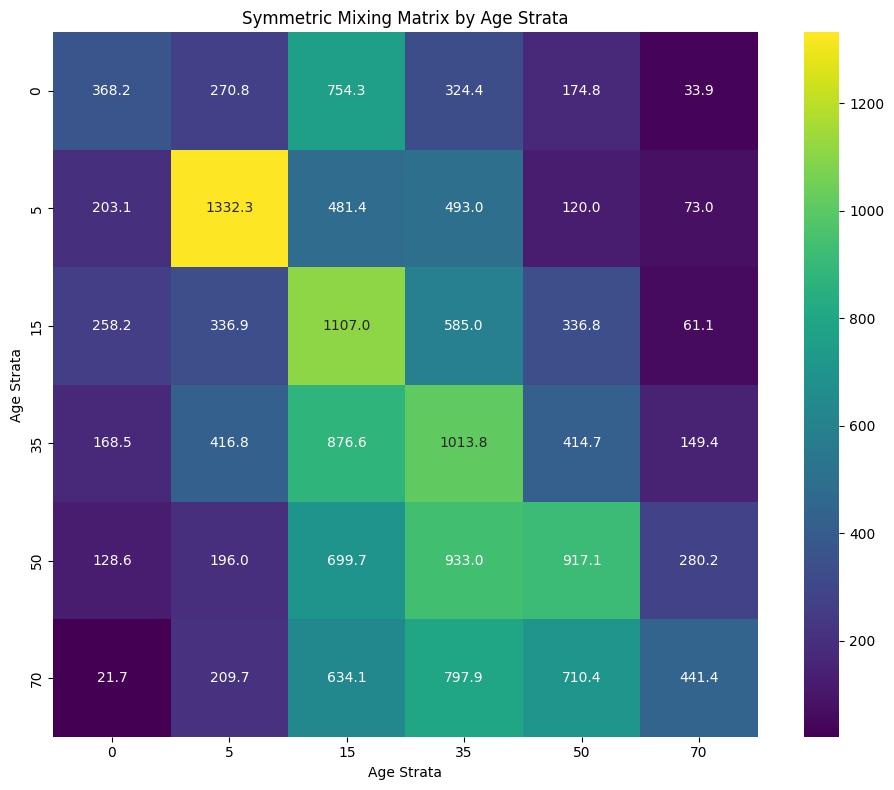

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt=".1f", cmap="viridis", xticklabels=age_strata, yticklabels=age_strata, square=True)
plt.title('Symmetric Mixing Matrix by Age Strata')
plt.xlabel('Age Strata')
plt.ylabel('Age Strata')
plt.tight_layout()
plt.show()
